# Tuned Win Percentage Model

Binary Classification model to predict whether or not the away team will beat the home team in the next NLF game


uses TPOT for HPO, model selection and feature selection

### Config


In [1]:
cd ../../..

c:\Users\charl\Desktop\Git\nfl-model-store


c:\Users\charl\Desktop\Git\nfl-model-store\venv\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [61]:
from src.data_registry import DataRegistry
from src.utils import get_dataframe, df_rename_dif
from src.modeling.utils import plot_correlation, train_test_splitter
from src.modeling.tuning.xgboost_optuna_tuner import XgboostOptunaTuner
from datetime import datetime
from sklearn.metrics import accuracy_score
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

START_SEASON = 2002
RUN_SEASON = 2023
RUN_WEEK = None

FEATURE_STORE_GROUP = "event"
FEATURE_STORE_NAME = "regular_season_game"
EXPERIMENT_NAME = "win_percentage"
RUN_NAME = "TPOT"
METRIC = 'accuracy'
PRIMARY_METRIC_THRESHOLD = 0.65


data_registry = DataRegistry(feature_store_group=FEATURE_STORE_GROUP, feature_store_name=FEATURE_STORE_NAME)
registry_df = data_registry.make_dataset(start_season=START_SEASON, end_season=RUN_SEASON)

1. Change to diff instead of home and away
2. Correlations
3. Feature Selection
4. Model Tuning (HPO)
5. Model Evaluation
6. Feature Importances

In [62]:
TARGETS = [
    'home_score',
    'away_score',
    'away_team_win',
    'away_team_spread',
    'total_target',
    'away_team_covered',
    'home_team_covered',
    'under_covered',
    'away_team_covered_spread',   
]

META = [
    'season',
    'week',
    'home_team',
    'away_team',
]

VEGAS = [
    'spread_line',
    'total_line',
]

ELO = [
    'elo_pre',
    #'elo_prob',
]

EWMA_FEATURES = [
    'ewma_rushing_offense',
    'ewma_rushing_defense',
    'ewma_passing_offense',
    'ewma_passing_defense',
    'ewma_score_offense',
    'ewma_score_defense',
]

POINT_FEATURES = [
    'avg_points_offense',
    'avg_points_defense',
    'avg_point_differential_offense',
    'avg_point_differential_defense',
]

ROLLING_COVER_FEATURES = [    
    'rolling_spread_cover',
    'rolling_under_cover'
]

DOWN_FEATURES = [
    'avg_first_down_offense',
    'avg_first_down_defense',
    'avg_third_down_converted_offense',
    'avg_third_down_converted_defense',
    'avg_third_down_failed_offense',
    'avg_third_down_failed_defense',
    'avg_fourth_down_converted_offense',
    'avg_fourth_down_converted_defense',
    'avg_fourth_down_failed_offense',
    'avg_fourth_down_failed_defense',
    'avg_third_down_percentage_offense',
    'avg_third_down_percentage_defense',
    'avg_fourth_down_percentage_offense',
    'avg_fourth_down_percentage_defense',
    'avg_first_down_penalty_offense',
    'avg_first_down_penalty_defense',
]

FANTASY_FEATURES = [
    #'avg_fantasy_points_offense',
    #'avg_fantasy_points_defense',
    #'avg_fantasy_points_half_ppr_offense',
    #'avg_fantasy_points_half_ppr_defense',
    'avg_fantasy_points_ppr_offense',
    'avg_fantasy_points_ppr_defense',
]

COMMON_FEATURES = [
    'avg_total_plays_offense',
    'avg_total_plays_defense',
    'avg_total_yards_offense',
    'avg_total_yards_defense',
    'avg_total_fumbles_offense',
    'avg_total_fumbles_defense',
    'avg_total_fumbles_lost_offense',
    'avg_total_fumbles_lost_defense',
    'avg_total_turnovers_offense',
    'avg_total_turnovers_defense',
    'avg_total_touchdowns_offense',
    'avg_total_touchdowns_defense',
    'avg_total_first_downs_offense',
    'avg_total_first_downs_defense',
    'avg_touchdown_per_play_offense',
    'avg_touchdown_per_play_defense',
    'avg_yards_per_play_offense',
    'avg_yards_per_play_defense',
    'avg_fantasy_point_per_play_offense',
    'avg_fantasy_point_per_play_defense',
    'avg_penalty_yards',
    'avg_penalty',
    'avg_pass_to_rush_ratio_offense',
    'avg_pass_to_rush_ratio_defense',
    'avg_pass_to_rush_first_down_ratio_offense',
    'avg_pass_to_rush_first_down_ratio_defense',

]

COMMON_PASSING_FEATURES = [
    'avg_completions_offense',
    'avg_completions_defense',
    'avg_attempts_offense',
    'avg_attempts_defense',
    'avg_passing_yards_offense',
    'avg_passing_yards_defense',
    'avg_passing_tds_offense',
    'avg_passing_tds_defense',
    'avg_interceptions_offense',
    'avg_interceptions_defense',
    'avg_sacks_offense',
    'avg_sacks_defense',
    'avg_sack_yards_offense',
    'avg_sack_yards_defense',
    'avg_sack_fumbles_lost_offense',
    'avg_sack_fumbles_lost_defense',
    'avg_passing_air_yards_offense',
    'avg_passing_air_yards_defense',
    'avg_passing_yards_after_catch_offense',
    'avg_passing_yards_after_catch_defense',
    'avg_passing_first_downs_offense',
    'avg_passing_first_downs_defense',
    'avg_passing_epa_offense',
    'avg_passing_epa_defense',
    'avg_pacr_offense',
    'avg_pacr_defense',
    'avg_dakota_offense',
    'avg_dakota_defense',
    'avg_completion_percentage_offense',
    'avg_completion_percentage_defense',
    'avg_qbr_offense',
    'avg_qbr_defense',
    'avg_yards_per_pass_attempt_offense',
    'avg_yards_per_pass_attempt_defense',
    'avg_sack_rate_offense',
    'avg_sack_rate_defense',
    
]

COMMON_RUSHING_FEATURES = [
    'avg_carries_offense',
    'avg_carries_defense',
    'avg_rushing_yards_offense',
    'avg_rushing_yards_defense',
    'avg_rushing_tds_offense',
    'avg_rushing_tds_defense',
    'avg_rushing_fumbles_lost_offense',
    'avg_rushing_fumbles_lost_defense',
    'avg_rushing_first_downs_offense',
    'avg_rushing_first_downs_defense',
    'avg_rushing_epa_offense',
    'avg_rushing_epa_defense',
]

NGS_PASSING_FEATURES = [
    'avg_time_to_throw_offense',
    'avg_time_to_throw_defense',
    'avg_completed_air_yards_offense',
    'avg_completed_air_yards_defense',
    'avg_intended_air_yards_passing_offense',
    'avg_intended_air_yards_passing_defense',
    'avg_air_yards_differential_offense',
    'avg_air_yards_differential_defense',
    'avg_aggressiveness_offense',
    'avg_aggressiveness_defense',
    'avg_max_completed_air_distance_offense',
    'avg_max_completed_air_distance_defense',
    'avg_air_yards_to_sticks_offense',
    'avg_air_yards_to_sticks_defense',
    'avg_passer_rating_offense',
    'avg_passer_rating_defense',
    'avg_expected_completion_percentage_offense',
    'avg_expected_completion_percentage_defense',
    'avg_completion_percentage_above_expectation_offense',
    'avg_completion_percentage_above_expectation_defense',
    'avg_air_distance_offense',
    'avg_air_distance_defense',
    'avg_max_air_distance_offense',
    'avg_max_air_distance_defense',
    'avg_air_yards_per_pass_attempt_offense',
    'avg_air_yards_per_pass_attempt_defense',
]

NGS_RUSHING_FEATURES = [
    'avg_efficiency_offense',
    'avg_efficiency_defense',
    'avg_percent_attempts_gte_eight_defenders_offense',
    'avg_percent_attempts_gte_eight_defenders_defense',
    'avg_time_to_los_offense',
    'avg_time_to_los_defense',
    'avg_expected_rush_yards_offense',
    'avg_expected_rush_yards_defense',
    'avg_rush_yards_over_expected_offense',
    'avg_rush_yards_over_expected_defense',
    'avg_rush_yards_over_expected_per_att_offense',
    'avg_rush_yards_over_expected_per_att_defense',
    'avg_rush_pct_over_expected_offense',
    'avg_rush_pct_over_expected_defense',
    'avg_yards_per_rush_attempt_offense',
    'avg_yards_per_rush_attempt_defense',
]

NGS_RECEIVING_FEATURES = [
    'avg_cushion_offense',
    'avg_cushion_defense',
    'avg_separation_offense',
    'avg_separation_defense',
    'avg_intended_air_yards_receiving_offense',
    'avg_intended_air_yards_receiving_defense',
    'avg_yac_above_expectation_offense',
    'avg_yac_above_expectation_defense',
]

In [63]:
chucky_features = [
    'elo_pre', 
    'spread_line', 
    'total_line',    
    'ewma_rushing_offense',
    'ewma_rushing_defense',
    'ewma_passing_offense',
    'ewma_passing_defense',
    #'ewma_score_offense',
    #'ewma_score_defense',
    'avg_points_offense',
    'avg_points_defense',
    'avg_point_differential_offense',
    'avg_point_differential_defense',
    'avg_fantasy_points_ppr_offense',
    'avg_fantasy_points_ppr_defense',
    'avg_total_yards_offense',
    'avg_total_yards_defense',
    'avg_total_turnovers_offense',
    'avg_total_turnovers_defense',
    'avg_total_touchdowns_offense',
    'avg_total_touchdowns_defense',
    'avg_yards_per_play_offense',
    'avg_yards_per_play_defense',
    'avg_qbr_offense',
    'avg_qbr_defense',
    'avg_yards_per_pass_attempt_offense',
    'avg_yards_per_pass_attempt_defense',
    'avg_third_down_percentage_offense',
    'avg_third_down_percentage_defense',
]

In [64]:
target = 'away_team_win'

dataset = registry_df.copy()

features = VEGAS + ELO + EWMA_FEATURES + POINT_FEATURES +FANTASY_FEATURES+ DOWN_FEATURES+ COMMON_FEATURES + COMMON_PASSING_FEATURES + COMMON_RUSHING_FEATURES#+ NGS_PASSING_FEATURES+ NGS_RUSHING_FEATURES+ NGS_RECEIVING_FEATURES

t1_cols = [i for i in dataset.columns if 'away_' in i and (i not in TARGETS + META) and i.replace('away_', '') in features]
t2_cols = [i for i in dataset.columns if 'home_' in i and i not in TARGETS + META and i.replace('home_', '') in features ]
a = dataset[[target]+VEGAS+ t1_cols+t2_cols]
b = df_rename_dif(a.drop(columns=[target]+VEGAS), 'away_', 'home_', t1_cols=t1_cols, t2_cols=t2_cols)
dataset = pd.concat([a, b], axis=1)
data_features = dataset.columns.tolist() + ['season', 'week']

df = pd.concat([registry_df[['away_team', 'home_team', 'season', 'week']], dataset], axis=1)
df

,away_team,home_team,season,week,away_team_win,spread_line,total_line,away_ewma_score_offense,away_ewma_score_defense,away_avg_fantasy_points_ppr_offense,away_avg_fantasy_points_ppr_defense,away_avg_total_plays_offense,away_avg_total_plays_defense,away_avg_total_yards_offense,away_avg_total_yards_defense,away_avg_total_fumbles_offense,away_avg_total_fumbles_defense,away_avg_total_fumbles_lost_offense,away_avg_total_fumbles_lost_defense,away_avg_total_turnovers_offense,away_avg_total_turnovers_defense,away_avg_total_touchdowns_offense,away_avg_total_touchdowns_defense,away_avg_total_first_downs_offense,away_avg_total_first_downs_defense,away_avg_touchdown_per_play_offense,away_avg_touchdown_per_play_defense,away_avg_yards_per_play_offense,away_avg_yards_per_play_defense,away_avg_fantasy_point_per_play_offense,away_avg_fantasy_point_per_play_defense,away_avg_completions_offense,away_avg_completions_defense,away_avg_attempts_offense,away_avg_attempts_defense,away_avg_passing_yards_offense,away_avg_passing_yards_defense,away_avg_passing_tds_offense,away_avg_passing_tds_defense,away_avg_interceptions_offense,away_avg_interceptions_defense,away_avg_sacks_offense,away_avg_sacks_defense,away_avg_sack_yards_offense,away_avg_sack_yards_defense,away_avg_sack_fumbles_lost_offense,away_avg_sack_fumbles_lost_defense,away_avg_passing_air_yards_offense,away_avg_passing_air_yards_defense,away_avg_passing_yards_after_catch_offense,away_avg_passing_yards_after_catch_defense,away_avg_passing_first_downs_offense,away_avg_passing_first_downs_defense,away_avg_passing_epa_offense,away_avg_passing_epa_defense,away_avg_pacr_offense,away_avg_pacr_defense,away_avg_dakota_offense,away_avg_dakota_defense,away_avg_completion_percentage_offense,away_avg_completion_percentage_defense,away_avg_qbr_offense,away_avg_qbr_defense,away_avg_pass_to_rush_ratio_offense,away_avg_pass_to_rush_ratio_defense,away_avg_pass_to_rush_first_down_ratio_offense,away_avg_pass_to_rush_first_down_ratio_defense,away_avg_yards_per_pass_attempt_offense,away_avg_yards_per_pass_attempt_defense,away_avg_sack_rate_offense,away_avg_sack_rate_defense,away_avg_carries_offense,away_avg_carries_defense,away_avg_rushing_yards_offense,away_avg_rushing_yards_defense,away_avg_rushing_tds_offense,away_avg_rushing_tds_defense,away_avg_rushing_fumbles_lost_offense,away_avg_rushing_fumbles_lost_defense,away_avg_rushing_first_downs_offense,away_avg_rushing_first_downs_defense,away_avg_rushing_epa_offense,away_avg_rushing_epa_defense,away_ewma_rushing_offense,away_ewma_rushing_defense,away_ewma_passing_offense,away_ewma_passing_defense,away_avg_penalty_yards,away_avg_penalty,away_avg_points_offense,away_avg_points_defense,away_avg_point_differential_offense,away_avg_point_differential_defense,away_avg_first_down_offense,away_avg_first_down_defense,away_avg_third_down_converted_offense,away_avg_third_down_converted_defense,away_avg_third_down_failed_offense,away_avg_third_down_failed_defense,away_avg_fourth_down_converted_offense,...,dif_avg_fantasy_points_ppr_defense,dif_avg_total_plays_offense,dif_avg_total_plays_defense,dif_avg_total_yards_offense,dif_avg_total_yards_defense,dif_avg_total_fumbles_offense,dif_avg_total_fumbles_defense,dif_avg_total_fumbles_lost_offense,dif_avg_total_fumbles_lost_defense,dif_avg_total_turnovers_offense,dif_avg_total_turnovers_defense,dif_avg_total_touchdowns_offense,dif_avg_total_touchdowns_defense,dif_avg_total_first_downs_offense,dif_avg_total_first_downs_defense,dif_avg_touchdown_per_play_offense,dif_avg_touchdown_per_play_defense,dif_avg_yards_per_play_offense,dif_avg_yards_per_play_defense,dif_avg_fantasy_point_per_play_offense,dif_avg_fantasy_point_per_play_defense,dif_avg_completions_offense,dif_avg_completions_defense,dif_avg_attempts_offense,dif_avg_attempts_defense,dif_avg_passing_yards_offense,dif_avg_passing_yards_defense,dif_avg_passing_tds_offense,dif_avg_passing_tds_defense,dif_avg_interceptions_offense,dif_avg_interceptions_defense,dif_avg_sacks_offense,

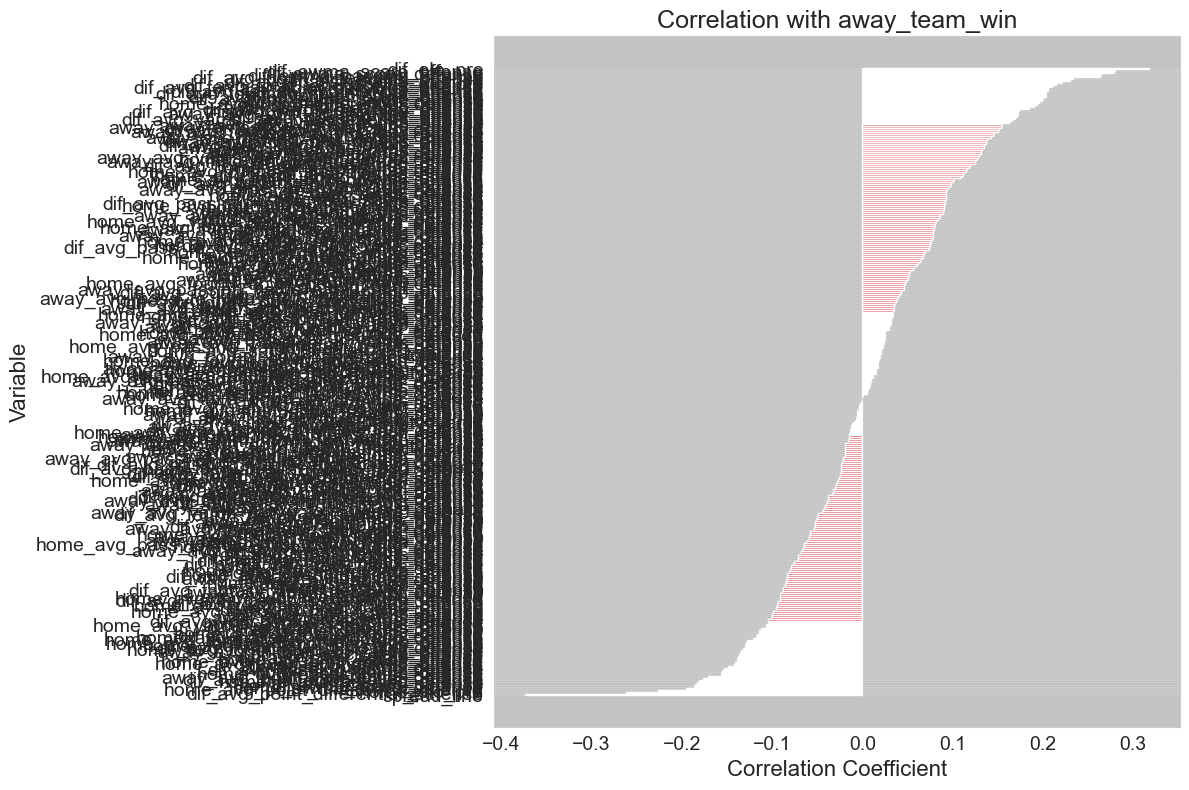

In [65]:
corr_fig = plot_correlation(df.drop(columns=['away_team', 'home_team']), data_features)
corr_fig

In [66]:
df = df.fillna(0)
X_train, y_train, X_test, y_test, metadata_test = train_test_splitter(df, data_features, start_season=START_SEASON, run_season=RUN_SEASON)
metadata_test

,home_team,away_team,season,week,away_team_win
5391,KC,DET,2023,1,1
5392,ATL,CAR,2023,1,0
5393,BAL,HOU,2023,1,0
5394,CLE,CIN,2023,1,0
5395,IND,JAX,2023,1,1
...,...,...,...,...,...
5658,LV,DEN,2023,18,0
5659,NYG,PHI,2023,18,0
5660,SF,LA,2023,18,1
5661,WAS,DAL,2023,18,1


In [67]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

metas = []
min_features_to_select = 4  # Minimum number of features to consider
clf = RandomForestClassifier(random_state=42, criterion='log_loss')
cv = StratifiedKFold(5)

rfecv = RFECV(
    estimator=clf,
    step=1,
    cv=cv,
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
    n_jobs=2,
    verbose=1
)
rfecv.fit(X_train, y_train)


Fitting estimator with 313 features.
Fitting estimator with 312 features.
Fitting estimator with 311 features.
Fitting estimator with 310 features.
Fitting estimator with 309 features.
Fitting estimator with 308 features.
Fitting estimator with 307 features.
Fitting estimator with 306 features.
Fitting estimator with 305 features.
Fitting estimator with 304 features.
Fitting estimator with 303 features.
Fitting estimator with 302 features.
Fitting estimator with 301 features.
Fitting estimator with 300 features.
Fitting estimator with 299 features.
Fitting estimator with 298 features.
Fitting estimator with 297 features.
Fitting estimator with 296 features.
Fitting estimator with 295 features.
Fitting estimator with 294 features.
Fitting estimator with 293 features.
Fitting estimator with 292 features.
Fitting estimator with 291 features.
Fitting estimator with 290 features.
Fitting estimator with 289 features.
Fitting estimator with 288 features.
Fitting estimator with 287 features.
F

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(criterion='log_loss', random_state=42),
      min_features_to_select=4, n_jobs=2, scoring='accuracy', verbose=1)

In [68]:
print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 42


In [72]:
features = X_test.columns[rfecv.get_support()]
features

Index(['spread_line', 'away_ewma_score_defense',
       'away_avg_total_plays_offense',
       'away_avg_pass_to_rush_first_down_ratio_offense',
       'away_avg_pass_to_rush_first_down_ratio_defense',
       'away_avg_sack_rate_defense', 'away_avg_rushing_epa_defense',
       'away_ewma_rushing_offense', 'away_ewma_passing_offense',
       'away_avg_penalty_yards', 'away_elo_pre',
       'home_avg_yards_per_play_defense', 'home_avg_sack_yards_offense',
       'home_avg_pass_to_rush_first_down_ratio_defense',
       'home_avg_rushing_yards_offense', 'home_avg_rushing_yards_defense',
       'home_ewma_rushing_offense', 'home_ewma_rushing_defense',
       'home_ewma_passing_offense', 'home_avg_penalty_yards',
       'home_avg_points_defense', 'home_elo_pre', 'dif_ewma_score_offense',
       'dif_ewma_score_defense', 'dif_avg_touchdown_per_play_offense',
       'dif_avg_touchdown_per_play_defense', 'dif_avg_passing_epa_offense',
       'dif_avg_dakota_offense', 'dif_avg_qbr_defense',
    

In [74]:


clf = RandomForestClassifier(random_state=42)
clf.fit(X_train[features], y_train)

print(f"Test Accuracy = {round(accuracy_score(y_test, clf.predict(X_test[features])), 4) * 100}%")

Test Accuracy = 65.44%


In [75]:
clf.feature_importances_

array([0.06051086, 0.02106332, 0.02112779, 0.02067226, 0.02045145,
       0.02142009, 0.02094335, 0.02192246, 0.02234209, 0.02183212,
       0.02384312, 0.02093364, 0.02116281, 0.02093058, 0.02175399,
       0.02206377, 0.02026411, 0.02226149, 0.02102783, 0.02093224,
       0.0208938 , 0.02573929, 0.0250485 , 0.02500523, 0.02173699,
       0.02024931, 0.02499036, 0.02670108, 0.02209592, 0.0216039 ,
       0.02236212, 0.02152294, 0.02085854, 0.02759241, 0.02203906,
       0.02236683, 0.02214283, 0.02760455, 0.03086207, 0.02302622,
       0.02076085, 0.03733786])

In [48]:
cv_results.mean_test_score.max()

0.6516461163621232

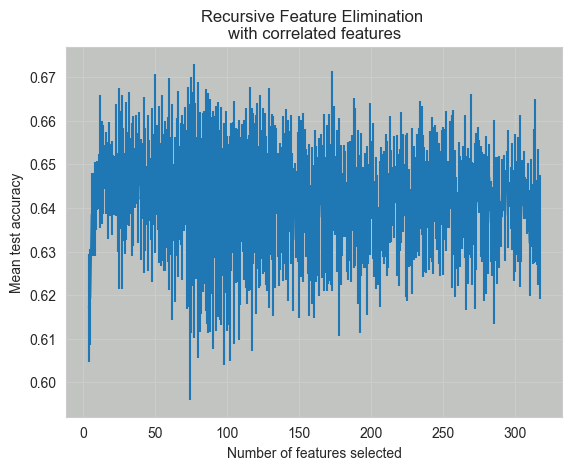

In [49]:
import matplotlib.pyplot as plt
import pandas as pd

cv_results = pd.DataFrame(rfecv.cv_results_)
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    x=cv_results["n_features"],
    y=cv_results["mean_test_score"],
    yerr=cv_results["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

### 3. Data Preparation

Data has already been prepared in the [feature store](https://github.com/theedgepredictor/nfl-feature-store)

We will use a train / test split of 2002-2022 seasons and 2023



In [26]:
import mlflow
import tpot2
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
from sklearn.metrics import  make_scorer, accuracy_score

mlflow.set_tracking_uri(uri='http://127.0.0.1:8080')

mlflow.set_experiment(experiment_name=EXPERIMENT_NAME)

with mlflow.start_run(run_name=RUN_NAME) as run:
    X_train, y_train, X_test, y_test, metadata_test = train_test_splitter(
        df, 
        data_features, 
        start_season=START_SEASON, 
        run_season=RUN_SEASON
    )

    mlflow.set_tags(
        {
            'data_features': data_features,
            'feature_store_group': FEATURE_STORE_GROUP,
            'feature_store_name': FEATURE_STORE_NAME,
            'model_name': 'RandomForestClassifier',
            'run_season': RUN_SEASON,
            'run_week': RUN_WEEK,
            'start_season': START_SEASON,
            'task': 'BinaryClassification',
            'task_primary_metric': METRIC,
            'task_primary_metric_threshold': PRIMARY_METRIC_THRESHOLD,
        }
    )

    clf = tpot2.TPOTClassifier(
        random_state = 1,
        #classification=True,
        n_jobs=4, 
        cv=5,
        scorers=[make_scorer(accuracy_score)],
        max_time_seconds=60 * 60 * 2,
        #generations=1,
        periodic_checkpoint_folder='./'
    )
    
    clf.fit(X_train, y_train)

    fitted_pipeline = clf._evolver_instance.population.evaluated_individuals.iloc[0]['Individual'].export_pipeline()

    val_accuracy = accuracy_score(y_test, clf.predict(X_test))
    mlflow.log_metric(key=METRIC, value=val_accuracy)

    if val_accuracy > 0.65:
        mlflow.sklearn.log_model(fitted_pipeline, 'model')
    else:
        print(f"Model accuracy: {val_accuracy} < 0.65. Skipping model export.")

    mlflow.end_run()

2024/09/17 18:50:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/09/17 18:50:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run baseline at: http://127.0.0.1:8080/#/experiments/662829350741144354/runs/ab8f40eabe794149ad288b966ca310aa.
2024/09/17 18:50:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:8080/#/experiments/662829350741144354.


In [27]:
fitted_pipeline

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('selectpercentile',
                 SelectPercentile(percentile=28.3358034930534)),
                ('featureunion-1',
                 FeatureUnion(transformer_list=[('skiptransformer',
                                                 SkipTransformer()),
                                                ('passthrough',
                                                 Passthrough())])),
                ('featureunion-2',
                 FeatureUnion(transformer_list=[('skiptransformer',
                                                 SkipTransformer()),
                                                ('passthrough',
                                                 Passthrough())])),
                ('lgbmclassifier',
                 LGBMClassifier(boosting_type='dart', max_depth=2,
                                n_estimators=46, n_jobs=1, num_leaves=81,
                                random_state=1, verbose=-1))])

In [ ]:
### Create this for single point estimate so we double the dataset.

In [ ]:


def plot_correlation_with_demand(df, save_path=None):
    """
    Plots the correlation of each variable in the dataframe with the 'demand' column.

    Args:
    - df (pd.DataFrame): DataFrame containing the data, including a 'demand' column.
    - save_path (str, optional): Path to save the generated plot. If not specified, plot won't be saved.

    Returns:
    - None (Displays the plot on a Jupyter window)
    """

    # Compute correlations between all variables and 'demand'
    correlations = df.corr()["demand"].drop("demand").sort_values()

    # Generate a color palette from red to green
    colors = sns.diverging_palette(10, 130, as_cmap=True)
    color_mapped = correlations.map(colors)

    # Set Seaborn style
    sns.set_style(
        "whitegrid", {"axes.facecolor": "#c2c4c2", "grid.linewidth": 1.5}
    )  # Light grey background and thicker grid lines

    # Create bar plot
    fig = plt.figure(figsize=(12, 8))
    plt.barh(correlations.index, correlations.values, color=color_mapped)

    # Set labels and title with increased font size
    plt.title("Correlation with Demand", fontsize=18)
    plt.xlabel("Correlation Coefficient", fontsize=16)
    plt.ylabel("Variable", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(axis="x")

    plt.tight_layout()

    # Save the plot if save_path is specified
    if save_path:
        plt.savefig(save_path, format="png", dpi=600)

    # prevent matplotlib from displaying the chart every time we call this function
    plt.close(fig)

    return fig

def model_tuning_pipeline():
        X_train, y_train, X_test, y_test, metadata_test = train_test_splitter(df, data_features, start_season, run_season, run_week=run_week, metadata_cols=metadata_cols)

    ## 1. Correlations
    ## 2. Feature Selection
    ## 3. Change to diff instead of home and away
    ## 4. Model Tuning (HPO)
    ## 5. Model Evaluation
    ## 6. Feature Importances

### 4. Model Building



**Baseline Model**
- Random Forest Classifier with default parameters

Test Accuracy = 64.42%


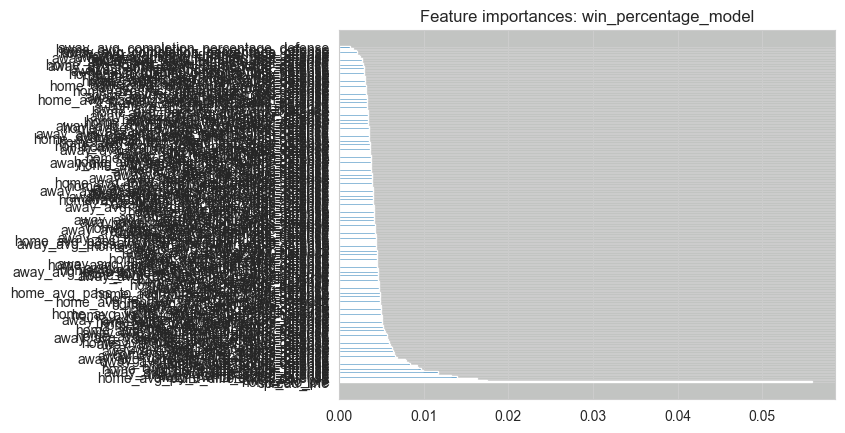

In [16]:
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
rf = RandomForestClassifier(random_state=42,max_depth=10)
rf.fit(X_train, y_train)

print(f"Test Accuracy = {round(scorer(rf, X_test, y_test), 4) * 100}%")

feature_importances = dict(zip(data_features[1:], rf.feature_importances_))
feature_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
features_sorted = [feature for feature, _ in feature_importances]
coef_sorted = [coef for _, coef in feature_importances]

ax.set_title(f'Feature importances: {EXPERIMENT_NAME}')

ax.barh(features_sorted, coef_sorted)
plt.show()
plt.close()

In [22]:
features_sorted

['spread_line',
 'home_elo_pre',
 'away_elo_pre',
 'away_ewma_score_offense',
 'away_ewma_passing_offense',
 'home_avg_point_differential_offense',
 'home_avg_point_differential_defense',
 'away_ewma_score_defense',
 'home_ewma_passing_offense',
 'home_ewma_score_offense',
 'away_ewma_rushing_offense',
 'home_ewma_score_defense',
 'away_avg_yards_per_pass_attempt_offense',
 'away_ewma_rushing_defense',
 'home_ewma_rushing_defense',
 'away_avg_point_differential_defense',
 'away_avg_third_down_percentage_offense',
 'home_ewma_rushing_offense',
 'home_avg_yards_per_pass_attempt_defense',
 'home_ewma_passing_defense',
 'home_avg_yards_per_pass_attempt_offense',
 'home_avg_yards_per_play_defense',
 'away_avg_point_differential_offense',
 'away_ewma_passing_defense',
 'home_avg_third_down_percentage_offense',
 'away_avg_third_down_percentage_defense',
 'home_avg_fantasy_points_ppr_defense',
 'away_avg_total_turnovers_offense',
 'away_avg_fantasy_points_ppr_offense',
 'away_avg_yards_per_pla

Test Accuracy = 59.56%


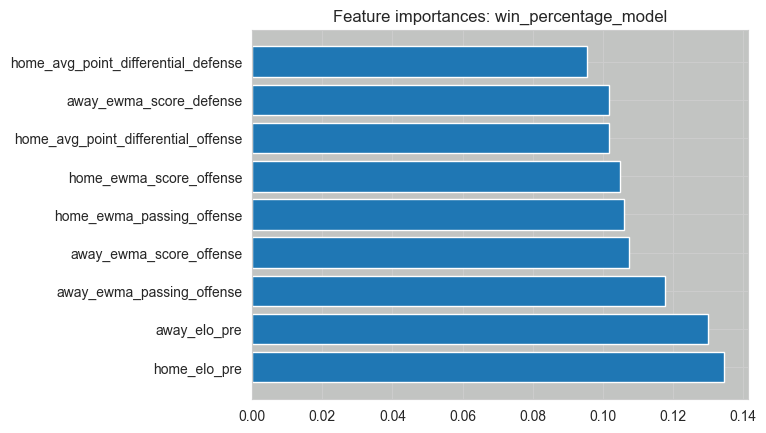

In [23]:
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train[features_sorted[1:10]], y_train)

print(f"Test Accuracy = {round(accuracy_score(y_test, clf.predict(X_test[features_sorted[1:10]])), 4) * 100}%")

feature_importances = dict(zip(features_sorted[1:10], clf.feature_importances_))
feature_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
features_sorteda = [feature for feature, _ in feature_importances]
coef_sorteda = [coef for _, coef in feature_importances]

ax.set_title(f'Feature importances: {EXPERIMENT_NAME}')

ax.barh(features_sorteda, coef_sorteda)
plt.show()
plt.close()

### 5. Model Evaluation



In [100]:
meta_df = df[df['season'] == END_SEASON][['season','week','home_team','away_team', 'spread_line', 'away_team_win', 'away_team_vegas_prediction', 'away_elo_prob']].copy()
meta_df['away_team_win_percentage_prediction'] = clf.predict(X_test) # meta_df['away_elo_prob'].round().astype(int)

print(f"{EXPERIMENT_NAME} Accuracy {analysis_season} = {round(accuracy_score(meta_df['away_team_win'], meta_df['away_team_win_percentage_prediction']), 4) * 100}%")

model_incorrect_df = meta_df[(meta_df['season'] == analysis_season) & (meta_df['away_team_win'] != meta_df['away_team_win_percentage_prediction'])].copy()
print(f"{EXPERIMENT_NAME} Incorrect Records {END_SEASON} per week")
print(model_incorrect_df.groupby(['week'])['season'].count().reset_index().sort_values(by='season', ascending=False)[0:10])

print(f"{EXPERIMENT_NAME} Incorrect Records {END_SEASON} per team")
folded_df = model_incorrect_df.copy()
folded_df['ishome'] = folded_df['home_team']
folded_df = df_rename_fold(folded_df, 'away_','home_')
folded_df = df_rename_fold(folded_df, '_away','_home')
folded_df = folded_df.drop_duplicates(['season','week','team'])
folded_df['ishome'] = folded_df['ishome'] == folded_df['team']

print(folded_df.groupby(['team'])['season'].count().reset_index().sort_values(by='season', ascending=False))

model_incorrect_df[model_incorrect_df['week'] == 14]

baseline_win_percentage_model Accuracy 2023 = 67.28%
baseline_win_percentage_model Incorrect Records 2023 per week
    week  season
15    16       8
13    14       8
17    18       7
6      7       7
11    12       6
0      1       6
2      3       6
7      8       5
4      5       5
5      6       4
baseline_win_percentage_model Incorrect Records 2023 per team
   team  season
9   DEN      10
26  PIT      10
2   BAL       8
1   ATL       8
11   GB       7
12  HOU       7
21   NE       7
29   TB       7
14  JAX       7
20  MIN       6
15   KC       6
31  WAS       6
24  NYJ       6
10  DET       6
6   CIN       6
28   SF       6
22   NO       6
7   CLE       5
17  LAC       5
18   LV       5
25  PHI       5
30  TEN       5
27  SEA       4
0   ARI       4
23  NYG       4
13  IND       4
5   CHI       4
3   BUF       4
19  MIA       3
16   LA       3
8   DAL       2
4   CAR       2


,season,week,home_team,away_team,spread_line,away_team_win,away_team_vegas_prediction,away_elo_prob,away_team_win_percentage_prediction
5584,2023,14,PIT,NE,6.0,1,0,0.328238,0
5585,2023,14,ATL,TB,1.5,1,0,0.471295,0
5587,2023,14,CHI,DET,-3.0,0,1,0.636195,1
5588,2023,14,CIN,IND,3.0,0,0,0.331855,1
5591,2023,14,NYJ,HOU,-3.5,0,1,0.528138,1
5595,2023,14,LAC,DEN,3.0,1,0,0.395985,0
5597,2023,14,MIA,TEN,14.0,1,0,0.27904,0
5598,2023,14,NYG,GB,-6.0,0,1,0.581631,1


In [ ]:
import mlflow



### 6. Model Deployment